# **DỰ BÁO GIÁ CHỨNG KHOÁN**

Đoạn mã dưới đây bao gồm các bước sử dụng mô hình LSTM đơn biến để dự báo giá chứng khoán của Công ty Cổ phần Viễn thông FPT:

1. Thu thập dữ liệu từ thư viện vnstock và tiến hành tiền xử lý dữ liệu.

2. Chuẩn bị dữ liệu huấn luyện.

3. Xây dựng mô hình LSTM.

4. Tối ưu hóa tham số mô hình bằng phương pháp Bayesian.

5. Huấn luyện mô hình với tham số tối ưu.

6. Đánh giá mô hình qua các chỉ số đánh giá MSE, RMSE, MAPE, R².

7. Đánh giá kết quả thông qua biểu đồ trực quan.

#CHUẨN BỊ CÁC THƯ VIỆN

In [ ]:
!pip install vnstock
!pip install vnstock3 --upgrade
!pip install optuna

In [ ]:
import numpy as np
import pandas as pd
import sys
import optuna
import seaborn as sns
np.random.seed(1)
import datetime as dt
import time
import tensorflow as tf
tf.random.set_seed(2)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# Lấy dữ liệu từ thư viện vnstock
from vnstock import Quote

#TIỀN XỬ LÝ DỮ LIỆU

Lấy dữ liệu

In [ ]:
# Lấy dữ liệu giá cổ phiếu FPT từ vnstock
quote = Quote(symbol="FPT", source="VCI")
start_date = "2019-11-20"
end_date = "2024-11-20"
data = quote.history(start=start_date, end=end_date)

df = pd.DataFrame(data)
print(data)


           time    open    high     low   close   volume
0    2019-11-20   24.64   24.64   23.96   24.05  2291760
1    2019-11-21   24.05   24.18   23.67   23.71  3303950
2    2019-11-22   23.84   24.18   23.50   23.71  1625820
3    2019-11-25   23.75   24.13   23.62   23.96  1087990
4    2019-11-26   24.13   24.22   24.05   24.18   968690
...         ...     ...     ...     ...     ...      ...
1247 2024-11-15  134.37  134.76  131.69  132.98  6574421
1248 2024-11-18  133.08  133.67  131.59  133.08  3910975
1249 2024-11-19  132.58  132.68  129.00  129.10  7652727
1250 2024-11-20  129.10  131.49  125.83  131.49  8474055
1251 2024-11-21  131.49  132.08  130.10  132.08  3183165

[1252 rows x 6 columns]


Xử lý dữ liệu

In [ ]:
# Chuyển đổi dữ liệu về dạng DataFrame và xử lý
if df is not None:
    df = pd.DataFrame(df)
    df.set_index('time', inplace=True)
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
else:
    raise ValueError("Không thể lấy dữ liệu từ vnstock. Vui lòng kiểm tra kết nối hoặc mã cổ phiếu.")

# Loại bỏ các hàng có volume = 0
df.drop(df[df['volume'] == 0].index, inplace=True)

In [ ]:
# Chọn biến huấn luyện
series = df['close']

# Chia dữ liệu thành các tập Train, Validation và Test
train_data = series.loc["2019-11-20":"2022-11-20"].values.reshape(-1, 1)
val_data = series.loc["2022-11-21":"2023-11-20"].values.reshape(-1, 1)
test_data = series.loc["2023-11-21":"2024-11-20"].values.reshape(-1, 1)

# Chuẩn hoá dữ liệu
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

#XÂY DỰNG MÔ HÌNH

Xây dựng và huấn luyện mô hình trên tập train và validation

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80, verbose=1, mode='min')
callbacks_list = [earlystop]

def fit_model(train, val, timesteps, hl, lr, batch, epochs):
    X_train, Y_train, X_val, Y_val = [], [], [], []

    # Chuẩn bị dữ liệu train
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Chuẩn bị dữ liệu validation
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Xây dựng mô hình
    model = Sequential()
    model.add(LSTM(hl[0], input_shape=(X_train.shape[1], 1), activation='relu', return_sequences=True))
    for i in range(1, len(hl) - 1):
        model.add(LSTM(hl[i], activation='relu', return_sequences=True))
    model.add(LSTM(hl[-1], activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss='mean_squared_error')

    # Huấn luyện mô hình
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch, validation_data=(X_val, Y_val), verbose=0, shuffle=False)
    return model, history.history['loss'], history.history['val_loss']

Đánh giá và dự đoán trên tập test

In [ ]:
def evaluate_model(model, test, timesteps):
    X_test = []
    Y_test = []

    # Chuẩn bị dữ liệu test
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Dự đoán
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

Tối ưu hoá các tham số

In [ ]:
# Hàm mục tiêu để tối ưu hoá các tham số với Bayesian Optimization
def objective(trial):
    timesteps = trial.suggest_int('timesteps', 20, 60, step=10)
    hl = [trial.suggest_int(f'hl_{i}', 20, 50, step=5) for i in range(2)]
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    num_epochs = trial.suggest_int('num_epochs', 50, 300, step=50)

    model, train_loss, val_loss = fit_model(train, val, timesteps, hl, lr, batch_size, num_epochs)

    mse, rmse, mape, r2, _, _ = evaluate_model(model, test, timesteps)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)


[I 2025-01-03 16:41:24,362] A new study created in memory with name: no-name-67521fe2-6e12-4f1e-85fb-6fa3791738e2
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


[I 2025-01-03 16:46:10,262] Trial 0 finished with value: 2024.6966454922187 and parameters: {'timesteps': 60, 'hl_0': 50, 'hl_1': 45, 'lr': 0.00017688357683282567, 'batch_size': 16, 'num_epochs': 100}. Best is trial 0 with value: 2024.6966454922187.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2025-01-03 16:49:09,917] Trial 1 finished with value: 0.16230034899525192 and parameters: {'timesteps': 40, 'hl_0': 20, 'hl_1': 25, 'lr': 0.0031330242393836434, 'batch_size': 64, 'num_epochs': 300}. Best is trial 1 with value: 0.16230034899525192.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


[I 2025-01-03 16:54:27,481] Trial 2 finished with value: 0.5707728398814051 and parameters: {'timesteps': 50, 'hl_0': 30, 'hl_1': 30, 'lr': 0.00022973969559173665, 'batch_size': 16, 'num_epochs': 150}. Best is trial 1 with value: 0.16230034899525192.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-01-03 16:55:25,447] Trial 3 finished with value: 0.057779990073404515 and parameters: {'timesteps': 40, 'hl_0': 35, 'hl_1': 30, 'lr': 0.0005519828769944935, 'batch_size': 32, 'num_epochs': 50}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


[I 2025-01-03 16:57:00,812] Trial 4 finished with value: 1.370052202246479 and parameters: {'timesteps': 20, 'hl_0': 45, 'hl_1': 50, 'lr': 0.0005746396596235907, 'batch_size': 128, 'num_epochs': 300}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


[I 2025-01-03 17:00:17,771] Trial 5 finished with value: 746.190529989329 and parameters: {'timesteps': 60, 'hl_0': 25, 'hl_1': 20, 'lr': 0.0008749203714091197, 'batch_size': 64, 'num_epochs': 300}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2025-01-03 17:02:10,052] Trial 6 finished with value: 9.453744800368007 and parameters: {'timesteps': 30, 'hl_0': 50, 'hl_1': 30, 'lr': 0.0003140093945402495, 'batch_size': 64, 'num_epochs': 200}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


[I 2025-01-03 17:05:59,726] Trial 7 finished with value: 13.528253385872178 and parameters: {'timesteps': 60, 'hl_0': 20, 'hl_1': 20, 'lr': 0.00591792902470528, 'batch_size': 16, 'num_epochs': 100}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


[I 2025-01-03 17:07:48,985] Trial 8 finished with value: 0.14941759395065904 and parameters: {'timesteps': 40, 'hl_0': 25, 'hl_1': 40, 'lr': 0.0028047317339779214, 'batch_size': 32, 'num_epochs': 100}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


[I 2025-01-03 17:12:40,443] Trial 9 finished with value: 0.8394468557381006 and parameters: {'timesteps': 40, 'hl_0': 30, 'hl_1': 20, 'lr': 0.008793431118177202, 'batch_size': 16, 'num_epochs': 200}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


[I 2025-01-03 17:13:15,473] Trial 10 finished with value: 0.4122371175791981 and parameters: {'timesteps': 20, 'hl_0': 40, 'hl_1': 35, 'lr': 0.00011530696723137564, 'batch_size': 32, 'num_epochs': 50}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


[I 2025-01-03 17:13:54,683] Trial 11 finished with value: 0.18277900242502607 and parameters: {'timesteps': 30, 'hl_0': 35, 'hl_1': 40, 'lr': 0.002038368983653225, 'batch_size': 32, 'num_epochs': 50}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2025-01-03 17:15:59,733] Trial 12 finished with value: 0.12845825942530545 and parameters: {'timesteps': 50, 'hl_0': 35, 'hl_1': 40, 'lr': 0.001510149975237556, 'batch_size': 32, 'num_epochs': 100}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


[I 2025-01-03 17:17:04,000] Trial 13 finished with value: 0.07899095077436588 and parameters: {'timesteps': 50, 'hl_0': 40, 'hl_1': 35, 'lr': 0.0012449391439904908, 'batch_size': 32, 'num_epochs': 50}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


[I 2025-01-03 17:18:12,368] Trial 14 finished with value: 0.06182542340293687 and parameters: {'timesteps': 50, 'hl_0': 45, 'hl_1': 30, 'lr': 0.0005070975424054844, 'batch_size': 32, 'num_epochs': 50}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[I 2025-01-03 17:19:05,998] Trial 15 finished with value: 63.93379495747092 and parameters: {'timesteps': 30, 'hl_0': 40, 'hl_1': 30, 'lr': 0.0004844706938787541, 'batch_size': 128, 'num_epochs': 150}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2025-01-03 17:20:13,604] Trial 16 finished with value: 0.3886389552733411 and parameters: {'timesteps': 50, 'hl_0': 45, 'hl_1': 25, 'lr': 0.0006108240472333911, 'batch_size': 32, 'num_epochs': 50}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2025-01-03 17:25:12,167] Trial 17 finished with value: 0.22380206688993087 and parameters: {'timesteps': 50, 'hl_0': 45, 'hl_1': 25, 'lr': 0.0004566107361547965, 'batch_size': 32, 'num_epochs': 250}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2025-01-03 17:27:53,968] Trial 18 finished with value: 0.07602840835068489 and parameters: {'timesteps': 40, 'hl_0': 30, 'hl_1': 35, 'lr': 0.0008190134027427062, 'batch_size': 32, 'num_epochs': 150}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


[I 2025-01-03 17:28:23,592] Trial 19 finished with value: 41.90556072602473 and parameters: {'timesteps': 40, 'hl_0': 40, 'hl_1': 30, 'lr': 0.0002918705524312894, 'batch_size': 128, 'num_epochs': 50}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[I 2025-01-03 17:29:34,287] Trial 20 finished with value: 19183.346552677405 and parameters: {'timesteps': 30, 'hl_0': 35, 'hl_1': 25, 'lr': 0.00013516509733704424, 'batch_size': 32, 'num_epochs': 100}. Best is trial 3 with value: 0.057779990073404515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


[I 2025-01-03 17:32:11,176] Trial 21 finished with value: 0.019488066019010212 and parameters: {'timesteps': 40, 'hl_0': 30, 'hl_1': 35, 'lr': 0.0007308807020317016, 'batch_size': 32, 'num_epochs': 150}. Best is trial 21 with value: 0.019488066019010212.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2025-01-03 17:36:33,695] Trial 22 finished with value: 1223.9661599774704 and parameters: {'timesteps': 40, 'hl_0': 30, 'hl_1': 35, 'lr': 0.0003649125553482345, 'batch_size': 32, 'num_epochs': 250}. Best is trial 21 with value: 0.019488066019010212.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


[I 2025-01-03 17:39:27,068] Trial 23 finished with value: 0.8074769558981605 and parameters: {'timesteps': 50, 'hl_0': 25, 'hl_1': 30, 'lr': 0.0008454156453357692, 'batch_size': 32, 'num_epochs': 150}. Best is trial 21 with value: 0.019488066019010212.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2025-01-03 17:40:25,482] Trial 24 finished with value: 0.13778339966021702 and parameters: {'timesteps': 40, 'hl_0': 35, 'hl_1': 45, 'lr': 0.001276629293017871, 'batch_size': 32, 'num_epochs': 50}. Best is trial 21 with value: 0.019488066019010212.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


[I 2025-01-03 17:42:50,834] Trial 25 finished with value: 1.5421776451280562 and parameters: {'timesteps': 30, 'hl_0': 35, 'hl_1': 40, 'lr': 0.00021740582438030235, 'batch_size': 32, 'num_epochs': 200}. Best is trial 21 with value: 0.019488066019010212.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


[I 2025-01-03 17:44:57,322] Trial 26 finished with value: 1009.8358731338631 and parameters: {'timesteps': 50, 'hl_0': 45, 'hl_1': 30, 'lr': 0.0006599528533442957, 'batch_size': 32, 'num_epochs': 100}. Best is trial 21 with value: 0.019488066019010212.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


[I 2025-01-03 17:45:35,274] Trial 27 finished with value: 26296.09328314913 and parameters: {'timesteps': 60, 'hl_0': 30, 'hl_1': 35, 'lr': 0.00037068140042662213, 'batch_size': 64, 'num_epochs': 50}. Best is trial 21 with value: 0.019488066019010212.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-01-03 17:47:56,779] Trial 28 finished with value: 0.01223684422486827 and parameters: {'timesteps': 50, 'hl_0': 40, 'hl_1': 25, 'lr': 0.001801998520868284, 'batch_size': 128, 'num_epochs': 250}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


[I 2025-01-03 17:50:32,155] Trial 29 finished with value: 0.3009057021926683 and parameters: {'timesteps': 60, 'hl_0': 40, 'hl_1': 25, 'lr': 0.0021886579204044468, 'batch_size': 128, 'num_epochs': 250}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-01-03 17:52:19,387] Trial 30 finished with value: 0.061200990268591916 and parameters: {'timesteps': 30, 'hl_0': 50, 'hl_1': 45, 'lr': 0.005185218551393082, 'batch_size': 128, 'num_epochs': 250}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2025-01-03 17:54:21,587] Trial 31 finished with value: 0.049648232255968996 and parameters: {'timesteps': 30, 'hl_0': 50, 'hl_1': 50, 'lr': 0.004234320763808227, 'batch_size': 128, 'num_epochs': 250}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


[I 2025-01-03 17:55:30,372] Trial 32 finished with value: 0.07424975038078886 and parameters: {'timesteps': 20, 'hl_0': 50, 'hl_1': 50, 'lr': 0.0030617995199810288, 'batch_size': 128, 'num_epochs': 200}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-01-03 17:57:13,386] Trial 33 finished with value: 0.02921134995858631 and parameters: {'timesteps': 40, 'hl_0': 30, 'hl_1': 25, 'lr': 0.0045297320376902605, 'batch_size': 128, 'num_epochs': 300}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2025-01-03 17:58:53,461] Trial 34 finished with value: 0.026058752088579103 and parameters: {'timesteps': 40, 'hl_0': 25, 'hl_1': 25, 'lr': 0.004299236566082268, 'batch_size': 128, 'num_epochs': 300}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


[I 2025-01-03 18:00:31,822] Trial 35 finished with value: 0.020363530514799295 and parameters: {'timesteps': 40, 'hl_0': 20, 'hl_1': 25, 'lr': 0.008980877933965507, 'batch_size': 128, 'num_epochs': 300}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[I 2025-01-03 18:02:07,472] Trial 36 finished with value: 1899.5433476172605 and parameters: {'timesteps': 40, 'hl_0': 20, 'hl_1': 20, 'lr': 0.008746440428542399, 'batch_size': 128, 'num_epochs': 300}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


[I 2025-01-03 18:03:46,159] Trial 37 finished with value: 0.13910858132299447 and parameters: {'timesteps': 40, 'hl_0': 25, 'hl_1': 20, 'lr': 0.007007633581580479, 'batch_size': 128, 'num_epochs': 300}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2025-01-03 18:05:23,980] Trial 38 finished with value: 0.013486394505168912 and parameters: {'timesteps': 40, 'hl_0': 20, 'hl_1': 25, 'lr': 0.003748010374842921, 'batch_size': 128, 'num_epochs': 300}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2025-01-03 18:15:27,899] Trial 39 finished with value: 0.641127209160718 and parameters: {'timesteps': 50, 'hl_0': 20, 'hl_1': 25, 'lr': 0.0019318893148401516, 'batch_size': 16, 'num_epochs': 300}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


[I 2025-01-03 18:17:48,055] Trial 40 finished with value: 0.12312770581992433 and parameters: {'timesteps': 40, 'hl_0': 20, 'hl_1': 20, 'lr': 0.003373397996070088, 'batch_size': 64, 'num_epochs': 250}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-01-03 18:19:32,005] Trial 41 finished with value: 0.05817194426464973 and parameters: {'timesteps': 40, 'hl_0': 25, 'hl_1': 25, 'lr': 0.006506546267951361, 'batch_size': 128, 'num_epochs': 300}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


[I 2025-01-03 18:21:07,909] Trial 42 finished with value: 0.642475300526874 and parameters: {'timesteps': 40, 'hl_0': 20, 'hl_1': 20, 'lr': 0.009883322308313486, 'batch_size': 128, 'num_epochs': 300}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


[I 2025-01-03 18:22:49,152] Trial 43 finished with value: 0.11300933976601218 and parameters: {'timesteps': 40, 'hl_0': 25, 'hl_1': 25, 'lr': 0.002448314877107715, 'batch_size': 128, 'num_epochs': 300}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2025-01-03 18:24:29,454] Trial 44 finished with value: 0.7564406687518913 and parameters: {'timesteps': 40, 'hl_0': 20, 'hl_1': 30, 'lr': 0.0036942276894660806, 'batch_size': 128, 'num_epochs': 300}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2025-01-03 18:25:50,922] Trial 45 finished with value: 0.10358743881823801 and parameters: {'timesteps': 40, 'hl_0': 25, 'hl_1': 20, 'lr': 0.0016544410451638475, 'batch_size': 128, 'num_epochs': 250}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[I 2025-01-03 18:28:59,873] Trial 46 finished with value: 1.1759012305641183 and parameters: {'timesteps': 30, 'hl_0': 20, 'hl_1': 25, 'lr': 0.0054106796928262745, 'batch_size': 16, 'num_epochs': 150}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


[I 2025-01-03 18:30:42,034] Trial 47 finished with value: 0.04264222013580019 and parameters: {'timesteps': 50, 'hl_0': 25, 'hl_1': 30, 'lr': 0.007657093437300358, 'batch_size': 128, 'num_epochs': 200}. Best is trial 28 with value: 0.01223684422486827.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-01-03 18:33:52,937] Trial 48 finished with value: 0.00871939259074017 and parameters: {'timesteps': 50, 'hl_0': 20, 'hl_1': 25, 'lr': 0.002537554785518352, 'batch_size': 64, 'num_epochs': 300}. Best is trial 48 with value: 0.00871939259074017.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


[I 2025-01-03 18:36:39,438] Trial 49 finished with value: 0.048081399583713755 and parameters: {'timesteps': 60, 'hl_0': 20, 'hl_1': 30, 'lr': 0.002677637218058929, 'batch_size': 64, 'num_epochs': 250}. Best is trial 48 with value: 0.00871939259074017.


Best params: {'timesteps': 50, 'hl_0': 20, 'hl_1': 25, 'lr': 0.002537554785518352, 'batch_size': 64, 'num_epochs': 300}


Huấn luyện mô hình với tham số tối ưu

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


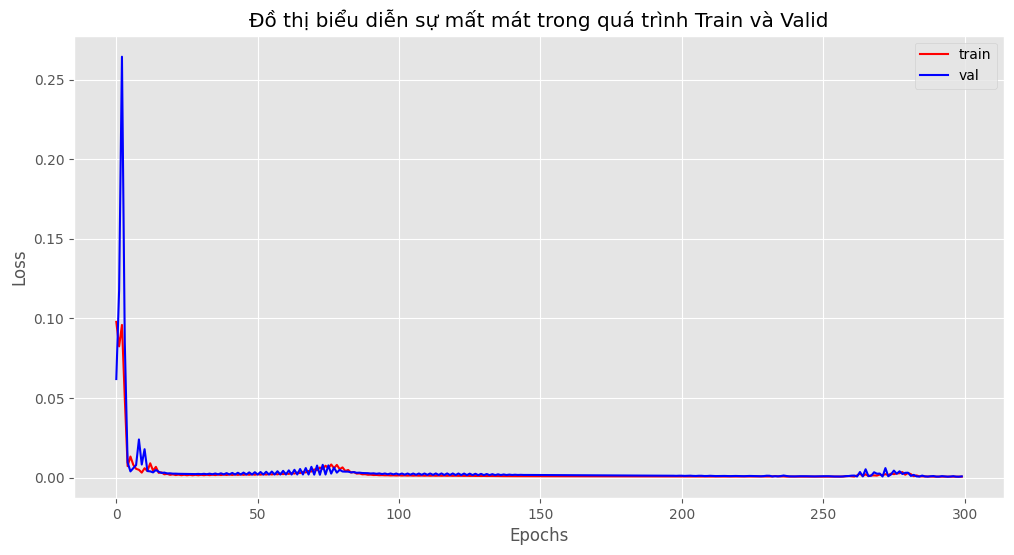

In [ ]:
timesteps = 50
hl = [20,25]
lr =  0.002537554785518352
batch_size = 64
num_epochs = 300

model, train_error, val_error = fit_model(train, val, timesteps, hl, lr, batch_size, num_epochs)

# Đồ thị biểu diễn sự mất mát trong quá trình huấn luyện và kiểm tra
def plot_error(train_loss, val_loss):
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Đồ thị biểu diễn sự mất mát trong quá trình Train và Valid')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()
plot_error(train_error, val_error)

#ĐÁNH GIÁ KẾT QUẢ

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MSE = 0.008220412572287865
RMSE = 0.09066649090092692
MAPE = 0.038787877693613956
R-Squared Score = 0.9156511417906498


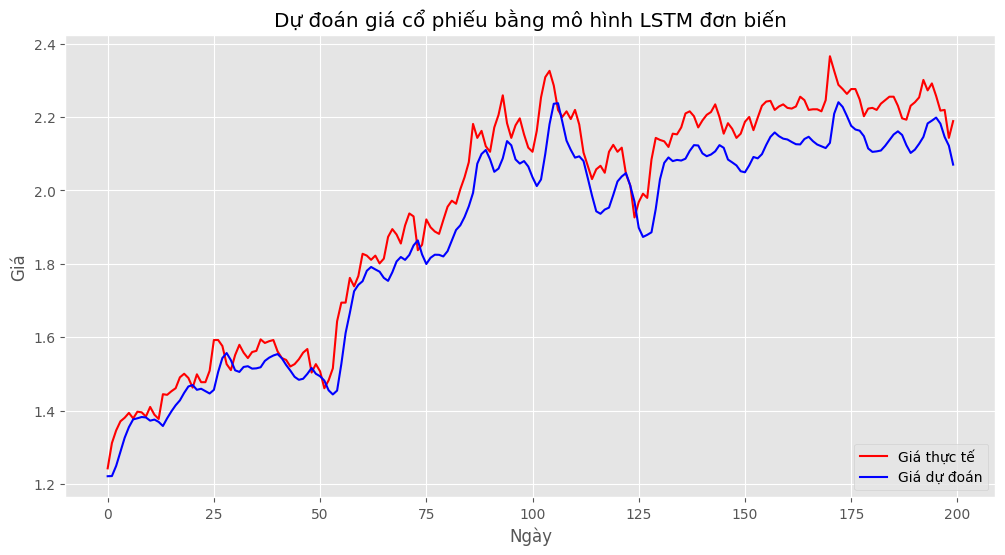

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model(model, test, timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

def plot_data(Y_test, Y_hat):
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test, color='r', label='Giá thực tế')
    plt.plot(Y_hat, color='b', label='Giá dự đoán')
    plt.xlabel('Ngày')
    plt.ylabel('Giá')
    plt.title("Dự đoán giá cổ phiếu bằng mô hình LSTM đơn biến")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
plot_data(true, predicted)

In [ ]:
# Tạo DataFrame từ giá trị thực tế và giá trị dự đoán
result_df = pd.DataFrame({
    'Actual': true.flatten(),
    'Predicted': predicted.flatten()
})

result_df['Giá thực tế'] = sc.inverse_transform(result_df[['Actual']])
result_df['Giá dự đoán'] = sc.inverse_transform(result_df[['Predicted']])
result_df['Chênh lệch'] = result_df['Giá thực tế'] - result_df['Giá dự đoán']
result_df = result_df.drop(columns=['Actual', 'Predicted'])

print("Bảng so sánh giá trị thực tế và dự đoán (Đơn vị: nghìn đồng):")
print(result_df.head(16))

Bảng so sánh giá trị thực tế và dự đoán (Đơn vị: nghìn đồng):
    Giá thực tế  Giá dự đoán  Chênh lệch
0         82.08    80.960075    1.119925
1         85.68    80.983864    4.696136
2         87.48    82.438835    5.041165
3         88.77    84.430367    4.339633
4         89.28    86.431778    2.848222
5         89.97    87.946892    2.023108
6         89.19    89.049385    0.140615
7         90.14    89.201241    0.938759
8         90.05    89.385170    0.664830
9         89.45    89.320496    0.129504
10        90.82    88.865303    1.954697
11        89.71    89.021202    0.688798
12        89.11    88.686989    0.423011
13        92.63    88.102737    4.527263
14        92.54    89.205246    3.334754
15        93.05    90.186722    2.863278
